<h2 style='color:blue' align='center'>Predicting Spam Messages or not</h2>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### *1. Load the Dataset*

Why Latin-1 encoding is used ?    
Some datasets contain special characters (e.g., accented letters, symbols) that are not properly handled by utf-8.

In [3]:
df = pd.read_csv("spam.csv" , encoding='latin-1')
df.head()

,Category,Messages,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.shape

(5572, 5)

### *2. Data Preprocessing*

In [3]:
df.isnull().sum()

Category         0
Messages         0
Unnamed: 2    5523
Unnamed: 3    5562
Unnamed: 4    5566
dtype: int64

In [4]:
df["Category"].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [5]:
df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"] , inplace=True)

In [6]:
df['Category'] = df['Category'].map({ 'ham' : 0 , 'spam' : 1 } )
df.head()

,Category,Messages
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df["Category"].value_counts()    # Ham -> 0 , Spam -> 1

Category
0    4825
1     747
Name: count, dtype: int64

In [8]:
df.duplicated().sum()

np.int64(403)

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df["Category"].value_counts()

Category
0    4516
1     653
Name: count, dtype: int64

### *3. Split Dataset into Training & Testing Sets*

In [8]:
X = df.Messages
y = df.Category

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2 , stratify=y , random_state=42)

In [10]:
X.shape , X_train.shape , X_test.shape

((5572,), (4457,), (1115,))

In [11]:
y.value_counts() , y_train.value_counts()  , y_test.value_counts()

(Category
 ham     4825
 spam     747
 Name: count, dtype: int64,
 Category
 ham     3859
 spam     598
 Name: count, dtype: int64,
 Category
 ham     966
 spam    149
 Name: count, dtype: int64)

### *4. Convert Text to Numerical Features**  
Use CountVectorizer and TF-IDF to convert text into numerical features.

#### Why Use `Pipeline`?
- **Simplifies Workflow**: Chains multiple steps (vectorization, transformation, classification) into one process.
- **Prevents Data Leakage**: Ensures the same transformations are applied to training & test data.
- **Easier Model Training**: One command (`pipeline.fit()`) handles everything.

#### Why Use `TF-IDF`?
- **TF (Term Frequency)**: Counts how often a word appears in a document.
- **IDF (Inverse Document Frequency)**: Reduces importance of common words (e.g., "the", "is").
- **Improves Accuracy**: Helps Naive Bayes focus on important words for classification.


In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [18]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2), stop_words='english')),  # Use bigrams & remove common words
    ('tfidf', TfidfTransformer(smooth_idf=True, sublinear_tf=True)),   # Improve term weighting
    ('classifier', MultinomialNB(alpha=0.1))  # Adjust Laplace smoothing for better probability estimation
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('classifier', MultinomialNB(alpha=0.1))])

`ngram_range=(1,2)` – Uses both single words & bigrams (two-word phrases) to better capture spam patterns like "free lottery".  

`stop_words`='english' – Removes common words (e.g., "the", "is") to focus on meaningful words.  

`smooth_idf=True, sublinear_tf=True` – Prevents large frequency words from dominating, improving classification.  

- Large dominating words mean words that appear very frequently in the dataset, such as "free," "offer," or "win" in spam messages. If these words are not handled properly, they can overshadow other important words, making the model biased.  

`alpha=0.1 in MultinomialNB` – Reduces smoothing (Laplace correction) for more accurate probability estimation.


### *5. Model Evaluation*

In [19]:
y_pred = pipeline.predict(X_test)

In [20]:
from sklearn.metrics import accuracy_score , confusion_matrix
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 98.45%


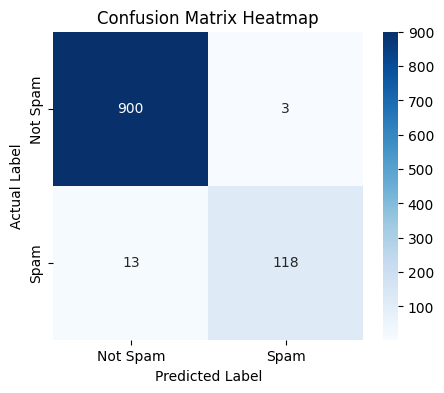

In [22]:
cm = confusion_matrix(y_test, y_pred)

# Create heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

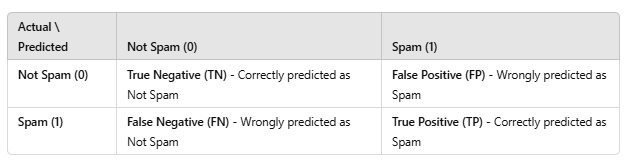

### *6. Test with a Custom Message*

In [20]:
msg = [
    "Congratulations! You've won a free lottery. Claim now.",  # Spam
    "Your account has been credited Rs50000",  # Spam
    "Meeting is scheduled at 3 PM. Please be on time.",  # Not Spam
    "Limited-time offer! Click the link to get 50% off.",  # Spam
    "Happy Birthday! Have a great day ahead.",  # Not Spam
]

predictions = pipeline.predict(msg)

for i, text in enumerate(msg):
    print(f"Message: {text}")
    print("Prediction:", "Spam" if predictions[i] == 1 else "Not Spam")
    print("-" * 50)

Message: Congratulations! You've won a free lottery. Claim now.
Prediction: Not Spam
--------------------------------------------------
Message: Your account has been credited Rs50000
Prediction: Not Spam
--------------------------------------------------
Message: Meeting is scheduled at 3 PM. Please be on time.
Prediction: Not Spam
--------------------------------------------------
Message: Limited-time offer! Click the link to get 50% off.
Prediction: Not Spam
--------------------------------------------------
Message: Happy Birthday! Have a great day ahead.
Prediction: Not Spam
--------------------------------------------------


In [25]:
train_pred = pipeline.predict(X_train)
train_score = accuracy_score( y_train , train_pred)

test_pred = pipeline.predict(X_test)
test_score = accuracy_score( y_test ,test_pred)

print("Training Accuracy : " , train_score*100)
print("Testing Accuracy : " , test_score*100)


Training Accuracy :  100.0
Testing Accuracy :  98.45261121856866


In [27]:
print("Training Confusion Matrix : \n" , confusion_matrix( y_train , train_pred))
print("Testing Confusion Matrix : \n" , confusion_matrix( y_test , test_pred))

Training Confusion Matrix : 
 [[3613    0]
 [   0  522]]
Testing Confusion Matrix : 
 [[900   3]
 [ 13 118]]


In [29]:
import joblib

joblib.dump(pipeline , "spam_model.pkl")

['spam_model.pkl']